# <u> Data Cleaning </u>

The purpose of this notebook is to perform all necessary data cleaning, feature engineering, and dataset preparation steps based on the exploratory data analysis conducted in the previous notebook (`01_eda.ipynb`).

## <u> 0. Import libraries and dataframes:</u>

In [12]:
# Import libraries
import pandas as pd
import numpy as np, os, sys, matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import MultiLabelBinarizer

# Set repository directory
current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import modules
from modules.data_cleaning import *
from modules.data_analysis import data_quality_summary

In [13]:
# Import dataframe
rating_df = pd.read_csv('../data/raw/rating.csv', parse_dates=["timestamp"])
movie_df = pd.read_csv('../data/raw/movie.csv')



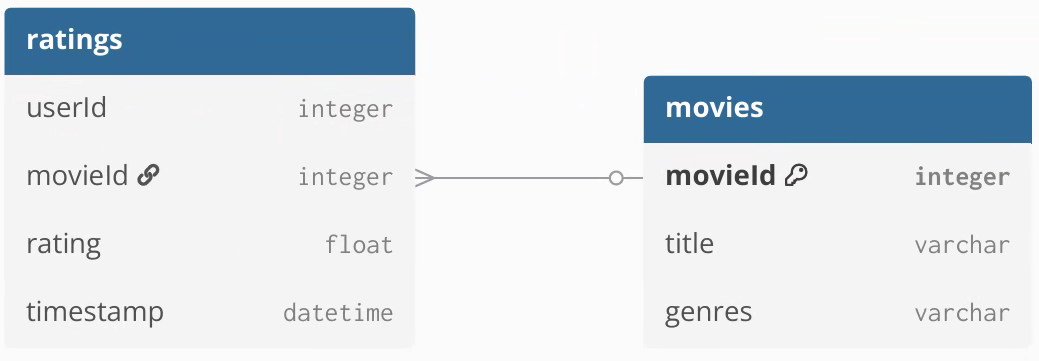

In [14]:
Image(filename='images/diagram_schema.png', width=650) 

## <u>1. Dataset Reduction and Alignment </u>

As a first step in the cleaning process, we reduce `ratings.csv` by randomly sampling 6,000 distinct users. We then filter to ensure that each movie has at least 10 reviews. Because this reduction also affects the minimum number of reviews per user (which must remain above 20), these two filtering steps are iterated until convergence to satisfy both conditions. This iterative process naturally decreases the total number of distinct users from the initial 6,000, but given the large size of the dataset, this reduction is acceptable to maintain data quality without significantly prolonging convergence.

In [15]:
# First we filter based on number of distincted users wanted
rating_df_adj = sample_users(rating_df, n_users=6000, random_state=12)

# Iteratively adjust rating_df_adj based on condition of minimum number of review
rating_df_adj, _ = iterative_filter(rating_df_adj, min_user_ratings=20, min_movie_ratings=10, max_iter=10)

# Find resulting valid movies
valid_movies = rating_df_adj['movieId'].unique()
movie_df_adj = movie_df[movie_df['movieId'].isin(valid_movies)].copy()

# Save cleaned datasets
rating_df_adj.to_csv("../data/processed/ratings.csv", index=False)
movie_df_adj.to_csv("../data/processed/movies.csv", index=False)

In [16]:
# Load cleaned datasets
rating_df = pd.read_csv("../data/processed/ratings.csv")
movie_df = pd.read_csv("../data/processed/movies.csv")

In [17]:
# Dataframe check
summary = data_quality_summary(rating_df, 'rating_df')


DATA QUALITY REPORT: rating_df

BASIC INFO:
  Rows: 850,111
  Columns: 4
  Memory Usage: 81.07 MB

 COLUMN SUMMARY:
              Type  Non-Null  Null  Null %  Unique  Unique %
userId       int64    850111     0     0.0    5976      0.70
movieId      int64    850111     0     0.0    6568      0.77
rating     float64    850111     0     0.0      10      0.00
timestamp   object    850111     0     0.0  670794     78.91

 DUPLICATES:
  Total duplicate rows: 0 (0.00%)




## <u>2. User-Movie Enriched Ratings (`base_rec_dataset`)</u>




In this initial preprocessing stage, I focus only on the ratings and movies tables to build a base dataset enriched with useful features such as genres, rating counts, and Bayesian-adjusted scores. This dataset is intended for traditional recommendation models like collaborative filtering, matrix factorization, or content-based approaches, which rely on user-item interactions or basic item attributes. At this stage, adding auxiliary information such as tags or genome scores would unnecessarily increase the feature space, potentially leading to higher computational costs and the risk of overfitting due to the curse of dimensionality. Such additional data becomes more useful in advanced models that aim to capture semantic similarity or leverage graph-based user-item relationships to extract richer information.

To construct this first dataset, the following steps will be applied:

- Merge dataframes using primary and foreign keys  
- Filter out:
  - Entries with missing values
  - Movies with fewer than 25 ratings  
  - Genre with "no genres listed"

- Compute and include the Bayesian average rating as a covariate  
- Include the popularity of each movie (i.e., number of ratings) as a covariate  
- Extract and include the release year from movie titles as a covariate  
- One-hot encode genres into a multi-hot vector and merge into the main movie dataframe   
- Log-transform skewed variables such as popularity  
- User-average rating: controls for user's personal rating tendency (generous or strict rater)
- User-average Bayesian rating: captures the average quality of movies the user tends to watch (preference trend)

In [7]:
# Remove tags missing values
tag_df_cleaned = tag_df.dropna()


# Only include movies with at least 25 reviews
movie_rating_count = (
    rating_df[['movieId', 'rating']]
    .groupby('movieId')
    .count()
    .rename(columns={'rating': 'rating_count'})
    .reset_index()
)

movieId_keep = movie_rating_count[movie_rating_count['rating_count'] >= 25]['movieId']
rating_df_cleaned = rating_df[rating_df['movieId'].isin(movieId_keep)].copy()


# Compute Bayesian rating
rating_df_grouped = rating_df_cleaned.groupby('movieId').agg(
    rating_count=('rating', 'count'),
    average_rating=('rating', 'mean')
).reset_index()

rating_df_grouped = pd.merge(movie_df[['movieId', 'title']], rating_df_grouped, on='movieId', how='right')
m = 20
C = rating_df_grouped['average_rating'].mean()
rating_df_grouped['Bayes_rating'] = ( (rating_df_grouped['rating_count'] / (rating_df_grouped['rating_count']+m))* rating_df_grouped['average_rating'] + 
                                    (m/(rating_df_grouped['rating_count'] +m)) * C )

# Map information into rating_df
movieId_B_rating_map = rating_df_grouped.set_index('movieId')['Bayes_rating']
rating_df_cleaned['movie_bayes_avg'] = rating_df_cleaned['movieId'].map(movieId_B_rating_map)


# Drop movies without genre
movie_df['genre_list'] = movie_df['genres'].str.split('|')
movies_exploded = movie_df.explode('genre_list')
rating_genre_df = pd.merge(rating_df_cleaned,movies_exploded[['movieId', 'genre_list']], on = 'movieId', how='left')
no_genre_movie_ids = rating_genre_df[rating_genre_df['genre_list'] == '(no genres listed)']['movieId'].unique()
rating_df_cleaned = rating_df_cleaned[~rating_df_cleaned['movieId'].isin(no_genre_movie_ids)].copy()
movie_df_cleaned = movie_df[~movie_df['movieId'].isin(no_genre_movie_ids)].copy()


# Log count rating per movies
rating_count_map = rating_df_grouped.set_index('movieId')['rating_count']
rating_df_cleaned['log_count_review'] = np.log1p(rating_df_cleaned['movieId'].map(rating_count_map))


# Extract year of release of the movies
movie_df['release_year']= (pd.to_datetime(movie_df['title'].str.extract(r'\((\d{4})\)')[0],
                                           format='%Y', errors='coerce').dt.year.astype('Int64'))
rating_df_cleaned = rating_df_cleaned.merge(
    movie_df[['movieId', 'release_year']], on='movieId', how='left'
)


# Multi hot-encoding genres
movie_df_cleaned = movie_df_cleaned[~movie_df_cleaned['genre_list'].apply(lambda genres: '(no genres listed)' in genres)].copy()
mlb = MultiLabelBinarizer()
genre_multi_hot = mlb.fit_transform(movie_df_cleaned['genre_list'])
genre_df = pd.DataFrame(genre_multi_hot, columns=mlb.classes_)
movie_df_f = pd.concat([movie_df_cleaned.reset_index(drop=True), genre_df], axis=1)


# Include users' average rating
rating_df_cleaned['user_avg_rating'] = rating_df_cleaned['userId'].map(
    rating_df_cleaned.groupby('userId')['rating'].mean()
)


# Include users' average Bayes rating of movie watched
rating_df_cleaned['user_avg_bayes'] = rating_df_cleaned['userId'].map(
    rating_df_cleaned.groupby('userId')['movie_bayes_avg'].mean())


# Filter users with at least 20 remaining ratings
user_rating_counts = rating_df_cleaned['userId'].value_counts()
eligible_users = user_rating_counts[user_rating_counts >= 20].index
rating_df_cleaned = rating_df_cleaned[rating_df_cleaned['userId'].isin(eligible_users)].copy()


In [14]:
# Define directory for storing processed data
save_dir = "../data/processed"

# Save ratings and movies separately
ratings_path = os.path.join(save_dir, "ratings_processed.parquet")
movies_path = os.path.join(save_dir, "movies_with_features.parquet")


In [15]:
# Save the files
rating_df_cleaned.to_parquet(ratings_path, index=False)
movie_df_f.to_parquet(movies_path, index=False)

### <u> Check dataframe:</u>

In [16]:
# Load them back to verify
ratings_processed = pd.read_parquet(ratings_path, engine="pyarrow")
movies_with_features = pd.read_parquet(movies_path, engine="pyarrow")

In [17]:
# Display sample rating processed data
pd.set_option('display.max_columns', None)
print("Ratings processed:")
print(f"\nShape: {ratings_processed.shape}")

Ratings processed:

Shape: (3575439, 9)


In [18]:
ratings_processed.head(3)

,userId,movieId,rating,timestamp,movie_bayes_avg,log_count_review,release_year,user_avg_rating,user_avg_bayes
0,1,2,3.5,2005-04-02 23:53:47,3.209239,8.291296,1995,3.744253,3.641414
1,1,29,3.5,2005-04-02 23:31:16,3.936319,7.355641,1995,3.744253,3.641414
2,1,32,3.5,2005-04-02 23:33:39,3.885264,8.995661,1995,3.744253,3.641414


In [19]:
# Display sample movies with features data
print("Movies with features:")
print(f"\nShape: {movies_with_features.shape}")

Movies with features:

Shape: (27032, 23)


In [20]:
movies_with_features.head(3)

,movieId,title,genres,genre_list,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
